In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [2]:
def plot_environment(env):
    plt.imshow(env, cmap='binary')
    plt.show()

def get_circle(radius, center, env_size):
    layer = np.zeros(env_size)
    for y in range(env_size[0]):
        for x in range(env_size[0]):
            if (y - center[0])**2+(x - center[1])**2 <= radius**2:
                layer[y,x] = 1
    return layer

def get_star(center, env_size, num_points, outer_radius, inner_radius):
    size = env_size[0]
    
    points = []
    for i in range(num_points * 2):
        angle = np.pi / num_points * i - np.pi / 2
        r = outer_radius if i % 2 == 0 else inner_radius
        x = center[0] + r * np.cos(angle)
        y = center[1] + r * np.sin(angle)
        points.append((x, y))

    star_path = Path(points)

    y, x = np.mgrid[0:size, 0:size]
    coords = np.vstack((x.ravel(), y.ravel())).T

    mask = star_path.contains_points(coords)
    star_array = mask.reshape((size, size))

    return star_array

In [ ]:
def random_circle_dynamic_env(env_size, n_circles, n_frames = 1):
    frame_list = []
    object_list = []

    # initialization of environment and objects
    
    for i in range(n_circles):
        radius = np.random.choice(np.arange(10))
        center_y, center_x = np.random.choice(np.arange(env_size[0])), np.random.choice(np.arange(env_size[0]))
        circle = get_circle(radius, (center_y, center_x), env_size)
        object_list.append(circle)
    frame = sum(object_list)
    frame_list.append(frame)
    # plot_environment(frame)

    object_dict = dict()
    if n_frames > 1:
        moving_objects = []
        static_objects = []
        for object in object_list: # 50% of the objects are moving
            if np.random.random() > 0.5:
                moving_objects.append(object)
            else:
                static_objects.append(object)
        
        
        for id, object in enumerate(moving_objects): # each object gets a direction, speed
        
            direction = np.random.choice(('UP', 'DOWN', 'LEFT', 'RIGHT'))
            speed = np.random.choice(np.arange(1,4))
            object_dict[id] = (direction, speed)
        
        for frame in range(1,n_frames):
            updated_moving_objects = []
            for id, object in enumerate(moving_objects):
                direction, speed = object_dict[id]
                updated_object = np.zeros(env_size)

                reset = False
                for y in range(env_size[0]):
                    for x in range(env_size[0]):
                        if object[y][x] == 1:
                            match direction:
                                case 'UP': 
                                    if y >= speed:
                                        updated_object[y-speed][x] = 1
                                    else:
                                        object_dict[id] = 'DOWN' , speed
                                        reset = True
                                case 'DOWN': 
                                    if y < env_size[0] - speed:
                                        updated_object[y+speed][x] = 1
                                    else:
                                        object_dict[id] = 'UP', speed
                                        reset = True
                                case 'LEFT': 
                                    if x >= speed:
                                        updated_object[y][x-speed] = 1
                                    else:
                                        object_dict[id] = 'RIGHT', speed
                                        reset = True
                                case 'RIGHT': 
                                    if x < env_size[0] - speed:
                                        updated_object[y][x+speed] = 1
                                    else:
                                        object_dict[id] = 'LEFT', speed
                                        reset = True
                if reset: 
                    updated_object = object
                updated_moving_objects.append(updated_object)
            moving_objects = updated_moving_objects
            frame = sum((*moving_objects, *static_objects))
            frame_list.append(frame)
    return frame_list

                            



frame_list = random_circle_dynamic_env((64,64), 10, 20)

In [3]:
def get_circular_trajectory(start, radius, speed, clock_wise = True):
        trajectory = []
        x, y = start
        x_0, y_0 =  start - np.array([radius, 0])
        angle_0 = np.arccos(x/(x_0+radius))
        

        linspace = np.linspace(angle_0, angle_0 + 2*np.pi, int(100/speed)) if clock_wise else reversed(np.linspace(angle_0, angle_0 + 2*np.pi, int(100/speed)))
        for angle in linspace:
            x =np.int64(np.around(x_0 + radius * np.cos(angle)))
            y = np.int64(np.around(y_0 + radius * np.sin(angle)))

            point = np.array([x,y])
            trajectory.append(point)


        return trajectory


def get_linear_trajectory(start, end, speed):
    trajectory = []
    start = np.array(start)
    end = np.array(end)
    vector = end - start
    norm = np.linalg.norm(vector)/speed
    vector_norm = vector/norm

    for i in range(1,int(norm)):
        x, y = start + i*vector_norm
        point = np.array([np.int64(np.around(x)), np.int64(np.around(y))])
        trajectory.append(point)

    trajectory.append(end)
    return trajectory

In [ ]:
def random_object_dynamic_env(env_size, n_objects, n_frames = 1):
    frame_list = []
    object_dict = dict()
    # points around the environment
    virtual_environment = np.ones(np.array(env_size) + 2) # virtual environment that is 1 pixel larger on each side
    virtual_environment[1:env_size[0]+1, 1:env_size[0]+1] = 0
    indices = np.where(virtual_environment == 1)
    virtual_points = np.array(list(zip(*indices))) - 1 # points that only exist in the virtual environment
    

    
    frame = np.zeros(env_size)
    for id in range(n_objects):
        center_y, center_x = np.random.choice(np.arange(env_size[0])), np.random.choice(np.arange(env_size[0]))

        if np.random.random() > 0.5:
            radius = np.random.choice(np.arange(10))
            object = get_circle(radius, (center_y, center_x), env_size)
            object_meta_data = radius
        else:
            num_points = np.random.choice(np.arange(3, 7))
            radius = np.random.choice(np.arange(5,8))
            inner_radius = np.random.choice(np.arange(1,5))
            object = get_star((center_y, center_x), env_size, num_points, radius, inner_radius)
            object_meta_data = [num_points, radius, inner_radius]

        if np.random.random() > 0.5 and n_frames > 1:
            start = center_y, center_x
            speed = np.random.choice(np.arange(0.25,1,0.25))
            if np.random.random() > 0.7:
                random_point = virtual_points[np.random.randint(len(virtual_points))]
                end_y, end_x = random_point
                # ensure that the whole object disappears, before reaching its destination
                if end_y == -1: end_y -= radius
                if end_y == env_size[0]: end_y += radius
                if end_x == -1: end_x -= radius
                if end_x == env_size[0]: end_x += radius
                end = end_y, end_x
                trajectory = get_linear_trajectory(start, end, speed)
                trajectory_type = 'linear'
            else:
                radius = np.random.choice(np.arange(env_size[0]/2, env_size[0]))
                if np.random.random() > 0.5:
                    clock_wise = True
                else:
                    clock_wise = False
                trajectory = get_circular_trajectory(start, radius, speed, clock_wise)
                trajectory_type = 'circular'
        else:
            trajectory = None
            trajectory_type = None

        object_dict[id] = [object, object_meta_data, trajectory, trajectory_type]
        frame += object
    frame_list.append(frame)



    for _ in range(1, n_frames):
        frame = np.zeros(env_size)
        for id, object_data in object_dict.items():
            object, object_meta_data, trajectory, trajectory_type = object_data


            if trajectory == None:
                frame += object

            elif trajectory == []:
                # spawn new object in the virtual space
                continue
            
            else:
                if isinstance(object_meta_data, list):
                    num_points, radius, inner_radius = object_meta_data
                    next_point = trajectory[0]
                    trajectory.remove(next_point)
                    frame += get_star(next_point, env_size, num_points, radius, inner_radius)
                else:
                    radius = object_meta_data
                    next_point = trajectory[0]
                    trajectory.remove(next_point)
                    frame += get_circle(radius, next_point, env_size)
                if trajectory_type == 'circular':
                    trajectory.append(next_point)
        frame_list.append(frame)
    
    return frame_list

In [13]:
frame_list = random_object_dynamic_env((64,64), 30, 100)

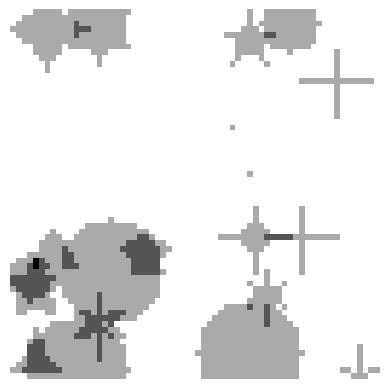

In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

frames = []

for frame in frame_list:
    plt.imshow(frame, cmap='binary')
    plt.axis('off')


    plt.savefig("temp.png", bbox_inches='tight', pad_inches=0)
    frames.append(Image.open("temp.png"))

# save as GIF
frames[0].save(
    "maze_animation.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0
)

In [ ]:
# generate frames for the reconstruction loss training

frames = []
for _ in range(1000):
    frame = random_object_dynamic_env((64, 64), 30, 1)
    frames.append(*frame)

np.save('environments.npy', frames)